In [1]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.las import *
from enveco.inception3dv3 import *
from enveco.tabular import *
from fastai.callback.progress import ShowGraphCallback

# Read data

In [2]:
basedir = Path('../../../andras/ml/AV_leafon/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))
df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


In [4]:
df.v.describe()

count    1269.000000
mean      146.608771
std        87.840874
min         2.310000
25%        81.350000
50%       132.600000
75%       191.380000
max       867.350000
Name: v, dtype: float64

In [56]:
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', bin_voxels=True, bottom_voxels=False, mask_plot=True,
                               y_block=RegressionBlock(), label_col='v', fn_col='sampleplotid', bs=32,
                               batch_tfms=[DihedralItem])

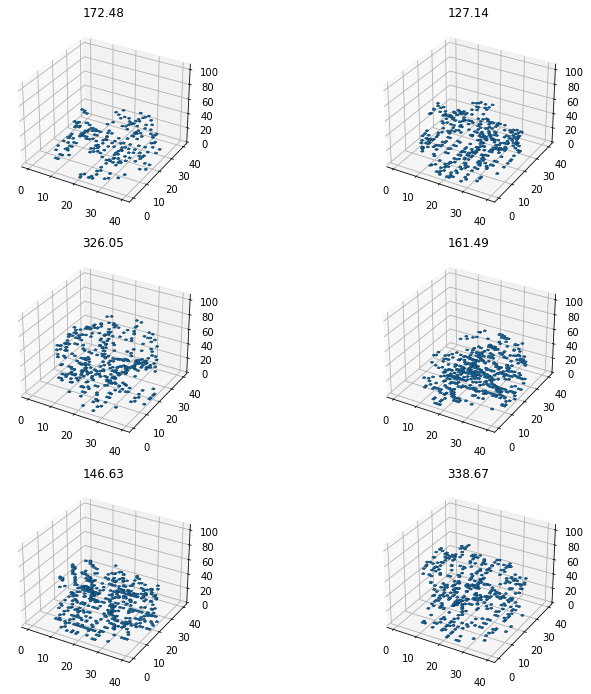

In [57]:
dls.show_batch()

In [58]:
dls.one_batch()

(VoxelImage size=32x1x105x40x40,
 tensor([266.5000,  45.0100, 273.3700, 263.4700, 133.0300, 116.5200, 174.1400,
         312.9900, 161.9500, 224.8600, 204.1000, 125.7700, 135.2500, 282.5000,
         169.4600, 123.3000, 336.4500, 127.9800, 185.4700,  29.7300, 156.6100,
          61.3000, 174.0600, 177.1500, 105.2600,  69.8500,  55.8800,  33.2500,
          64.4400, 153.7200, 126.9800, 251.1800], device='cuda:0'))

# Learner

Get predefined model.

In [59]:
inception = Inception3dV3()

/scratch/mayrajan/enveco/enveco/inception3dv3.py:124: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Create learner.

In [60]:
inc_learner = Learner(dls, inception, path='.', metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,900))

Search for a good learning rate

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.3182567499825382e-06)

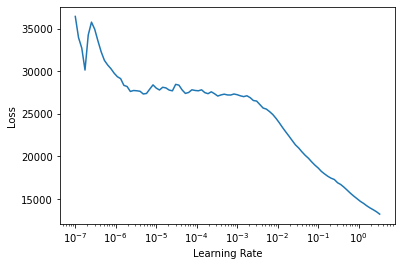

In [61]:
inc_learner.lr_find()

Fit with one cycle scheduling.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,27249.105469,30730.734375,175.301834,117.328575,-151.281586,-101.251945,151.281601,-2.888023,00:15
1,24924.978516,29167.458984,170.784836,114.305367,-151.587036,-101.456375,151.587036,-2.690239,00:15
2,20433.386719,21950.500000,148.157013,99.160683,-128.311829,-85.878410,128.311844,-1.777156,00:15
3,15754.743164,9197.989258,95.906151,64.189468,-84.330673,-56.442062,85.708633,-0.163721,00:15
4,11288.628906,6290.233887,79.310997,53.082420,-58.303856,-39.022457,66.553902,0.204166,00:15
5,7859.019043,4034.419434,63.517078,42.511635,-48.845333,-32.691917,55.163612,0.489569,00:15
6,5349.501465,6357.124512,79.731575,53.363914,-67.489822,-45.170574,68.135002,0.195703,00:15
7,3768.278809,2767.384521,52.605934,35.208866,-36.229794,-24.248404,40.121628,0.649873,00:15
8,2697.890869,1858.075073,43.105392,28.850206,-5.048244,-3.378763,30.216318,0.764918,00:15
9,2240.217773,1653.854980,40.667618,27.218616,-12.581594,-8.420792,28.464050,0.790756,00:15


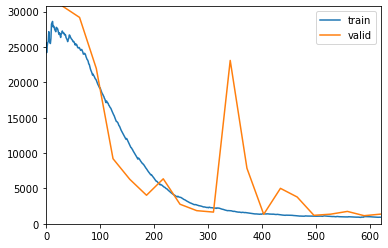

In [63]:
inc_learner.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

# See results

In [94]:
preds, true = inc_learner.get_preds()
preds

VoxelImage size=253x1

In [44]:
reg_interp = RegressionInterpretation.from_learner(inc_learner, ds_idx=1)

IndexError: too many indices for tensor of dimension 1

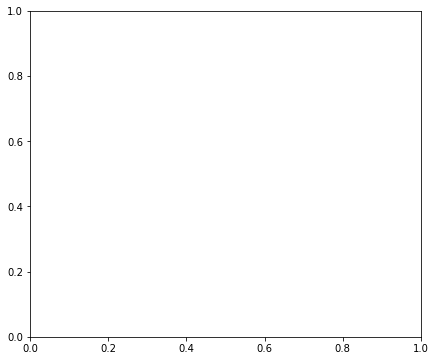

In [45]:
reg_interp.plot_results()
plt.show()